In [1]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.metrics import empirical_robustness

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [2]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [3]:
mnist = tf.keras.datasets.mnist # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data

# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [4]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [5]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (12665, 28, 28)
Lengh of dimensions for y_train:  (12665,)
Lengh of dimensions for x_test:  (2115, 28, 28)
Lengh of dimensions for y_test:  (2115,)


In [6]:
'''reshape'''
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

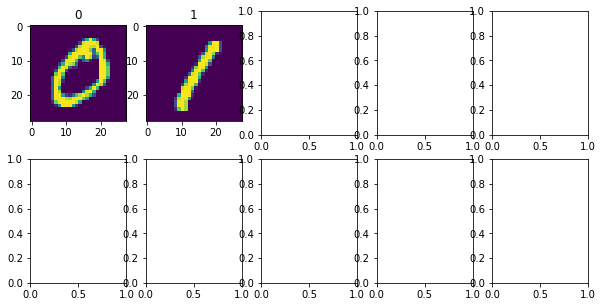

In [7]:
n_classes = 2
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [8]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [9]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
396/396 [==============================] - 5s 13ms/step - loss: 0.0491 - accuracy: 0.9810 - val_loss: 0.0026 - val_accuracy: 0.9991
Epoch 2/5
396/396 [==============================] - 4s 10ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9991
Epoch 3/5
396/396 [==============================] - 4s 11ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9991
Epoch 4/5
396/396 [==============================] - 4s 11ms/step - loss: 3.5030e-04 - accuracy: 0.9999 - val_loss: 9.6402e-04 - val_accuracy: 0.9995
Epoch 5/5
396/396 [==============================] - 4s 11ms/step - loss: 0.0018 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 0.9991


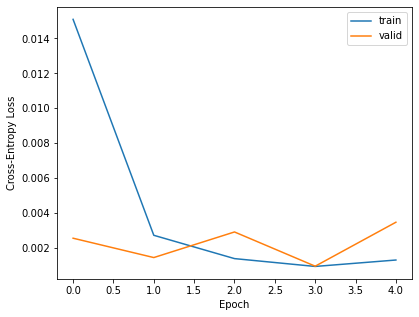

In [10]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

Test cross-entropy loss: 0.00348
Test accuracy: 0.99905


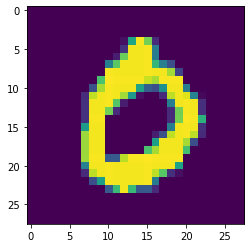

In [11]:
'''Score on original data'''
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(x_test[0])  
plt.show()

# FGSM L inf attack  

In [13]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(28,28,1),
                                   loss_object = loss_object, clip_values=(0, 1))
print('robustness of the undefended model', 
      empirical_robustness(classifier, x_test, 'fgsm', {}))

robustness of the undefended model 0.1689326334208225


In [14]:
#eps_list=np.arange(0.3, 0.6, 0.01)
#acc=np.zeros(eps_list.size)
#for i in range(eps_list.size):
#    '''
#    creat adversial examples using build in FastGradientMethod from ART
#    also predict based on the current  adversial examples
#    '''
#
#    adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps_list[i], targeted=False)
#    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
#    prediction_x = classifier.predict(x=adv_fgsm_x)
#    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
#    print(eps_list[i])

In [86]:
eps = 1
adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps, targeted=False)
adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
prediction_x = classifier.predict(x=adv_fgsm_x)

In [87]:
# print('class prediction for the adversarial sample:',classifier.predict(adv_fgsm_x))
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_fgsm_x, y_test)[1])

accuracy on adversarial examples:
67/67 [==============================] - 0s 3ms/step - loss: 1.0348 - accuracy: 0.7887
0.7886524796485901


Test cross-entropy loss: 1.03483
Test accuracy: 0.78865


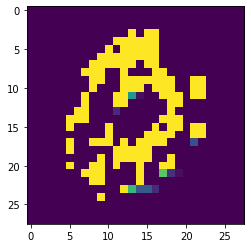

In [88]:
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()

# Building defense model, adversarial traning

In [89]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [90]:
'''creat a new untrained model and wrap it'''
new_model = model
new_model = TensorFlowV2Classifier(model=new_model,nb_classes=2, input_shape=(28,28,1),
                                  loss_object = loss_object, train_step=train_step)
#new_model = art.estimators.classification.KerasClassifier(model=new_model)


'''recall the attack model'''
adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps, targeted=False)


In [99]:
'''recall the wrap model'''
#classifier=TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(1,28,28,1), 
#                       loss_object = loss_object, train_step=(model, x_train, y_train))


#classifier = art.estimators.classification.KerasClassifier(model=new_model)


#tf.compat.v1.disable_eager_execution()
#classifier = TensorFlowV2Classifier(clip_values=(0,1), model=model )

'''define the attack we are using'''
adversarial_tranier = AdversarialTrainer(new_model, adv_fgsm_model, ratio = 0.5)

In [100]:
'''fitting the defence model'''
hi=adversarial_tranier.fit(x_train, y_train, batch_size=100, nb_epochs=5)


Test cross-entropy loss: 0.00253
Test accuracy: 0.99953


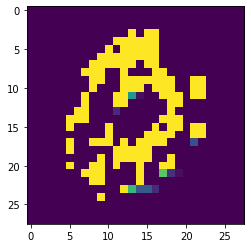

In [101]:
'''Score on adversarial examples'''
score = new_model._model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()

In [102]:
# print('class prediction for the adversarial sample:',classifier.predict(adv_fgsm_x))
print('accuracy on adversarial examples:' )
print(new_model._model.evaluate(adv_fgsm_x, y_test)[ 1 ] )

accuracy on adversarial examples:
67/67 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.9452
0.9451536536216736


# ----------------------------------

In [108]:
ratio_change = np.arange(0.1, 1, 0.1)
acc = []

for i in range(len(ratio_change)):
    new_model = model
    new_model = TensorFlowV2Classifier(model=new_model,nb_classes=2, input_shape=(28,28,1),
                                  loss_object = loss_object, train_step=train_step)
    adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps, targeted=False)
    adversarial_tranier = AdversarialTrainer(new_model, adv_fgsm_model, ratio = ratio_change[i])
    hi=adversarial_tranier.fit(x_train, y_train, batch_size=100, nb_epochs=5)
    print(new_model._model.evaluate(adv_fgsm_x, y_test)[ 1 ] )
    acc= new_model._model.evaluate(adv_fgsm_x, y_test)[ 1 ] 
    


67/67 [==============================] - 0s 3ms/step - loss: 0.5116 - accuracy: 0.8548
0.8548463582992554
67/67 [==============================] - 0s 3ms/step - loss: 0.5116 - accuracy: 0.8548



67/67 [==============================] - 0s 3ms/step - loss: 0.8097 - accuracy: 0.7196
0.7196217775344849
67/67 [==============================] - 0s 3ms/step - loss: 0.8097 - accuracy: 0.7196



67/67 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.8307
0.8307328820228577
67/67 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.8307



67/67 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9759
0.9758865237236023
67/67 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9759



67/67 [==============================] - 0s 3ms/step - loss: 0.5393 - accuracy: 0.8255
0.8255318999290466
67/67 [==============================] - 0s 3ms/step - loss: 0.5393 - accuracy: 0.8255



67/67 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.9272
0.9271867871284485
67/67 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.9272



67/67 [==============================] - 0s 3ms/step - loss: 0.5046 - accuracy: 0.8426
0.8425531983375549
67/67 [==============================] - 0s 4ms/step - loss: 0.5046 - accuracy: 0.8426



67/67 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9910
0.9910165667533875
67/67 [==============================] - 0s 4ms/step - loss: 0.0270 - accuracy: 0.9910



67/67 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.8648
0.8647754192352295
67/67 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.8648
